In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Timeseries_all_monthly_refined.csv').ffill()
# target_var = "ZuivelNL - Dutch butter quotation"
target_var = "ZuivelNL - Dutch SMP food quotation"

In [3]:
df['Date_Time'] = pd.to_datetime(df.apply(lambda x: x['date'][:10],axis=1))
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time

In [4]:
def remove_invalid_features(df, min_num_valid=100):
    v_check = df.ffill().isna().sum() < len(df) - min_num_valid
    v_feats = v_check[v_check].index.tolist()
    if 'date' in v_feats:
        v_feats.remove('date')
    if 'target' in v_feats:
        v_feats.remove('target')
    return [f for f in v_feats if len(df[f].unique()) > 1]
v_feats = remove_invalid_features(data)
time_horizon = 2
data = data[v_feats].diff(-time_horizon).dropna()
data

,ARG milk supply,AUS ARG milk supply,AUS milk supply,Belarus_and_Ukraine_milk_production,Brent crude oil price,Butter dummy,CME NDM price,CME butter price,CME whey price,China Dummy,...,ZuivelNL - US Lactose US$,ZuivelNL - US SMP price,ZuivelNL - US WMP price,ZuivelNL - US butter price,ZuivelNL - US cheddar block price,ZuivelNL - US whey price,ZuivelNL - world SMP price,ZuivelNL - world WMP price,ZuivelNL - world butter price,ZuivelNL - world cheddar price
Date_Time,,,,,,,,,,,,,,,,,,,,,
2012-01-01,13.2000,25.946731,12.746731,-340451438.0,-16.470000,0.0,5.200,14.250,3.240,0.0,...,0.0,242.000000,309.0,220.0,110.00000,374.000000,195.0,113.0,180.0,157.0
2012-02-01,-32.0000,-44.430160,-12.430160,-367137811.0,-4.068500,0.0,6.650,14.250,8.260,0.0,...,-66.0,265.000000,309.0,66.0,110.00000,287.000000,277.0,223.0,305.0,300.0
2012-03-01,-74.1000,-80.394181,-6.294181,-549828412.0,14.207500,0.0,13.350,0.850,4.880,0.0,...,-110.0,374.000000,352.0,287.0,44.00000,111.000000,392.0,447.0,536.0,312.0
2012-04-01,-39.6000,-25.506419,14.093581,-418391919.0,25.785000,0.0,19.070,1.750,10.320,0.0,...,66.0,154.000000,242.0,-177.0,-243.00000,66.000000,245.0,548.0,603.0,177.0
2012-05-01,-112.0000,-240.237728,-128.237728,391973607.0,11.480000,1.0,13.650,5.150,9.100,0.0,...,154.0,-241.000000,44.0,-530.0,-331.00000,-22.000000,-3.0,187.0,298.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01,107.5290,294.140922,186.611922,42800000.0,-2.832444,-1.0,-7.100,8.725,-2.500,0.0,...,-66.0,-156.525573,-110.0,330.0,656.94994,-55.114638,-170.0,55.0,125.0,-351.0
2019-12-01,224.6740,505.198000,280.524000,0.0,10.265000,0.0,-3.575,14.750,-2.300,0.0,...,-88.0,-78.813933,-22.0,331.0,496.01925,-50.705467,215.0,355.0,150.0,-237.0
2020-01-01,69.1770,203.382500,134.205500,0.0,15.407444,0.0,6.625,19.200,-2.350,0.0,...,-45.0,146.053792,0.0,177.0,180.77146,-51.807760,305.0,265.0,240.0,-465.0


In [5]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR
#creating the train and validation set
output_df = pd.DataFrame()
for i in range(36,1,-1):
    train = data.iloc[:-i-time_horizon]
    valid = data.iloc[-i]
    model = VAR(endog=train,freq='MS')
    model_fit = model.fit()
    # make prediction on validation
    prediction = model_fit.forecast(model_fit.y, steps=1)
    pred = pd.DataFrame(prediction,columns=data.columns)
    output_df  = output_df.append(pred*valid>0)
target_var = 'ZuivelNL - Dutch butter quotation'
output_df.mean()[target_var]

/Users/robbie/opt/anaconda3/envs/solar/lib/python3.8/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


0.4

In [6]:
#converting predictions to dataframe


In [7]:
#check rmse
from sklearn.metrics import mean_squared_error
for i in pred.columns:
#     print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i].values,valid[i].values)))
    print(f'dir_acc:{(valid[i]*pred[i]>0).mean()} feature:{i}')

dir_acc:0.0 feature:ARG milk supply
dir_acc:0.0 feature:AUS ARG milk supply
dir_acc:0.0 feature:AUS milk supply
dir_acc:0.0 feature:Belarus_and_Ukraine_milk_production
dir_acc:0.0 feature:Brent crude oil price
dir_acc:0.0 feature:Butter dummy
dir_acc:1.0 feature:CME NDM price
dir_acc:0.0 feature:CME butter price
dir_acc:1.0 feature:CME whey price
dir_acc:0.0 feature:China Dummy
dir_acc:1.0 feature:Chinese WMP stocks
dir_acc:0.0 feature:Dummy EU milk quota
dir_acc:0.0 feature:Dummy Russian import ban
dir_acc:0.0 feature:ETI
dir_acc:0.0 feature:ETI private
dir_acc:0.0 feature:EU SMP consumption
dir_acc:1.0 feature:EU SMP ending stocks
dir_acc:0.0 feature:EU SMP export availability
dir_acc:0.0 feature:EU SMP supply
dir_acc:0.0 feature:EU WMP consumption
dir_acc:1.0 feature:EU WMP ending stocks
dir_acc:1.0 feature:EU WMP export availability
dir_acc:0.0 feature:EU WMP supply
dir_acc:0.0 feature:EU butter balance
dir_acc:1.0 feature:EU butter consumption
dir_acc:1.0 feature:EU butter ending 

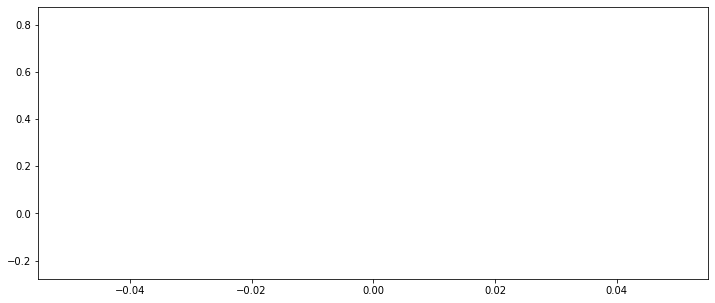

In [8]:
plt.figure(figsize=(12,5))
target_var = 'ZuivelNL - Dutch butter quotation'
# target_var = "ZuivelNL - Dutch SMP food quotation"
plt.plot(valid[target_var])
plt.plot(pred[target_var])

In [9]:
(valid[target_var]*pred[target_var]>0).mean()

0.0